In [1]:
# import the libraries and packages this project depends

import tensorflow as tf
import sklearn 
import cv2 
from skimage.transform import resize
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
import pydicom
from IPython.display import Image, display
import re

import SimpleITK as sitk



In [5]:
import tensorflow as tf

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))



Num GPUs Available: 1


In [2]:
# Import dataset with updated paths
dataset_img = np.load("/voletu/users/zhangnin/CODE/transfer_31361_files_9f28c4e7/tab_img3D_320_native_recad-dyn.npy", allow_pickle=True)
dataset_seg = np.load("/voletu/users/zhangnin/CODE/transfer_31361_files_9f28c4e7/tab_seg3D_320_native_recad-dyn.npy", allow_pickle=True)


In [7]:
print(np.unique(dataset_seg[1]))

[0. 1.]


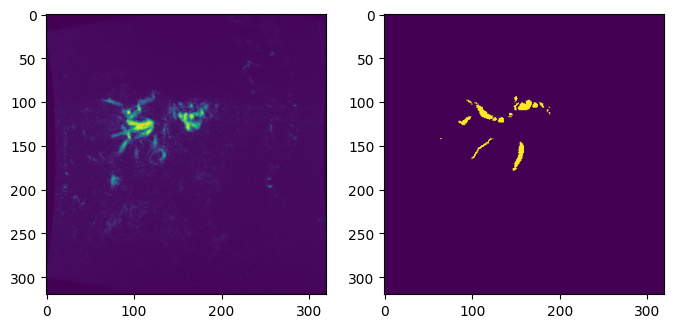

In [4]:
plt.figure(figsize=(8,8))
plt.subplot(221)
plt.imshow(dataset_img[39][40])
plt.subplot(222)
plt.imshow(dataset_seg[7][40])
plt.show()

In [9]:
def dice_coefficient(y_true, y_pred):      #mesure la similarité entre les prédictions et les vérités
    smooth = 1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_bce_loss(alpha):        #fonction de perte
    def loss(y_true, y_pred):
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        dice = 1 - dice_coefficient(y_true, y_pred)
        return (alpha * bce) + ((1 - alpha) * dice)
    return loss

In [10]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):          #convolutive
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model




In [11]:
model=build_unet(input_shape= (320,320,1), n_classes=1)
model.summary()
#from tensorflow.keras.utils import plot_model


# Générez le diagramme en "U" du modèle
#plot_model(model, to_file='/volper/users/aessamla/codes/Deep_learning/Data3D/model.png', show_shapes=True)

I0000 00:00:1739288782.983607 1470086 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1066 MB memory:  -> device: 0, name: NVIDIA A10, pci bus id: 0000:21:00.0, compute capability: 8.6


sigmoid


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 320, 320,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 320, 320,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 320, 320,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 320, 320,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 320, 320,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 320, 320,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 320, 320,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 160, 160,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 160, 160,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 160, 160,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 160, 160,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 160, 160,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 160, 160,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 160, 160,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 80, 80,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 80, 80,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │      1,024 │ conv2d_4[0][0]  

 Total params: 31,054,145 (118.46 MB)

 Trainable params: 31,042,369 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [8]:
#separate  into the folds
from sklearn.model_selection import KFold
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.losses import binary_crossentropy
#from tensorflow.keras.optimizers import Adam
from keras.optimizers import Adam
from keras import backend as K

kfold = KFold(n_splits=5, shuffle=True)
inputs=dataset_img
targets=dataset_seg


for fold_no, (train, test) in enumerate(kfold.split(inputs, targets), 1):
    # Afficher un message indiquant le débuta de l'entraînement pour ce fold
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Sélectionner les données d'entrée et de sortie (targets) pour ce fold
    y_train= targets[train]
    y_test= targets[test]
    X_train=inputs[train]
    X_test=inputs[test]

    ##np.save("/voletu/users/zhangnin/CODE/data/Folds_native_recad-dyn" + "/" + str(fold_no) + "_y_train.npy", y_train)
    ##np.save("/voletu/users/zhangnin/CODE/data/Folds_native_recad-dyn" + "/" + str(fold_no) + "_y_test.npy", y_test)
    ##np.save("/voletu/users/zhangnin/CODE/data/Folds_native_recad-dyn" + "/" + str(fold_no) + "_X_train.npy", X_train)
    ##np.save("/voletu/users/zhangnin/CODE/data/Folds_native_recad-dyn" + "/" + str(fold_no) + "_x_test.npy", X_test)

    save_path = "/voletu/users/zhangnin/CODE/data/Folds_native_recad-dyn/"

    if not os.path.exists(save_path):
        os.makedirs(save_path)


    np.save(save_path + str(fold_no) + "_y_train.npy", y_train)
    np.save(save_path + str(fold_no) + "_y_test.npy", y_test)
    np.save(save_path + str(fold_no) + "_X_train.npy", X_train)
    np.save(save_path + str(fold_no) + "_x_test.npy", X_test)


------------------------------------------------------------------------
Training for fold 1 ...
------------------------------------------------------------------------
Training for fold 2 ...
------------------------------------------------------------------------
Training for fold 3 ...
------------------------------------------------------------------------
Training for fold 4 ...
------------------------------------------------------------------------
Training for fold 5 ...


In [12]:
y_train = np.load("/voletu/users/zhangnin/CODE/data/Folds_native_recad-dyn/2_y_train.npy",allow_pickle=True)
y_test = np.load("/voletu/users/zhangnin/CODE/data/Folds_native_recad-dyn/2_y_test.npy",allow_pickle=True)
X_train = np.load("/voletu/users/zhangnin/CODE/data/Folds_native_recad-dyn/2_X_train.npy",allow_pickle=True)
X_test = np.load("/voletu/users/zhangnin/CODE/data/Folds_native_recad-dyn/2_x_test.npy",allow_pickle=True)

print(y_train.shape)
print(y_test.shape)
print(X_train.shape)
print(X_test.shape)         

(32,)
(8,)
(32,)
(8,)


In [13]:
y_train_2D = []                             #transform a 2D data
for i in range (len(y_train)):
    for j in range (y_train[i].shape[0]):
        y_train_2D.append(y_train[i][j])

y_test_2D = []
for i in range (len(y_test)):
    for j in range (y_test[i].shape[0]):
        y_test_2D.append(y_test[i][j])

X_train_2D = []
for i in range (len(X_train)):
    for j in range (X_train[i].shape[0]):
        X_train_2D.append(X_train[i][j])

X_test_2D = []
for i in range (len(X_test)):
    for j in range (X_test[i].shape[0]):
        X_test_2D.append(y_test[i][j])

In [14]:
y_train_2D = np.array(y_train_2D)
print(y_train_2D.shape)
y_train= np.expand_dims(y_train_2D, axis=-1)           #
print(y_train.shape)

y_test_2D = np.array(y_test_2D)
print(y_test_2D.shape)
y_test= np.expand_dims(y_test_2D, axis=-1)
print(y_test.shape)

X_train_2D = np.array(X_train_2D)
print(X_train_2D.shape)
X_train= np.expand_dims(X_train_2D, axis=-1)
print(X_train.shape)

X_test_2D = np.array(X_test_2D)
print(X_test_2D.shape)
X_test= np.expand_dims(X_test_2D, axis=-1)
print(X_test.shape)

(2744, 320, 320)
(2744, 320, 320, 1)
(744, 320, 320)
(744, 320, 320, 1)
(2744, 320, 320)
(2744, 320, 320, 1)
(744, 320, 320)
(744, 320, 320, 1)


In [16]:
from sklearn.model_selection import KFold
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.losses import binary_crossentropy
from focal_loss import BinaryFocalLoss
#from tensorflow.keras.optimizers import Adam
from keras.optimizers import Adam
#from keras import backend as K
from tensorflow.keras import backend as K



dice_per_fold=[]
loss_per_fold=[]
fold_no = 1

base_path = "/voletu/users/zhangnin/CODE/data/results_bce_dice_0.5/"

import os
if not os.path.exists(base_path):
    os.makedirs(base_path)


# Créer le modèle
model = build_unet(input_shape= (320,320,1), n_classes=1)
model.compile(optimizer="adam", loss=dice_bce_loss(alpha=0.5), metrics=[dice_coefficient])
#model.compile(optimizer="adam", loss=BinaryFocalLoss(gamma=2), metrics=[dice_coefficient])

# Entraîner le modèle
log_filename = base_path + 'training_fold_' + str(fold_no) + '.log'
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
callbacks_list = [early_stop, CSVLogger(log_filename)]
history = model.fit(X_train, y_train, 
                epochs=100, batch_size=4, 
                validation_data=(X_test, y_test), 
                verbose=1,
                callbacks=[callbacks_list])
model.save(base_path + str(fold_no) + '.h5')


# Generate generalization metrics
scores = model.evaluate(X_test, y_test, verbose=0)
print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
dice_per_fold.append(scores[1])
loss_per_fold.append(scores[0])

np.save(base_path + 'dice_fold_' + str(fold_no) + '.npy', dice_per_fold)
np.save(base_path + 'loss_fold_' + str(fold_no) + '.npy', loss_per_fold)

sigmoid


2025-02-11 16:55:15.056840: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:497] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.05GiB (rounded to 1123942400)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-02-11 16:55:15.056912: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1053] BFCAllocator dump for GPU_0_bfc
2025-02-11 16:55:15.056936: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1060] Bin (256): 	Total Chunks: 89, Chunks in use: 89. 22.2KiB allocated for chunks. 22.2KiB in use in bin. 11.2KiB client-requested in use in bin.
2025-02-11 16:55:15.056953: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1060] Bin (512): 	Total Chunks: 42, Chunks in use: 42. 21.2KiB allocated for chunks. 21.2KiB in use in bin. 21.0KiB client-requested in use in bin.
2

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

 4. 5.62MiB allocated for chunks. 4.50MiB in use in bin. 4.50MiB client-requested in use in bin.
2025-02-11 16:55:15.057130: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1060] Bin (2097152): 	Total Chunks: 8, Chunks in use: 6. 18.08MiB allocated for chunks. 13.75MiB in use in bin. 13.00MiB client-requested in use in bin.
2025-02-11 16:55:15.057144: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1060] Bin (4194304): 	Total Chunks: 6, Chunks in use: 4. 31.22MiB allocated for chunks. 18.00MiB in use in bin. 18.00MiB client-requested in use in bin.
2025-02-11 16:55:15.057159: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1060] Bin (8388608): 	Total Chunks: 7, Chunks in use: 6. 64.00MiB allocated for chunks. 55.00MiB in use in bin. 52.00MiB client-requested in use in bin.
2025-02-11 16:55:15.057174: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1060] Bin (16777216): 	Total Chunks: 8, Chunks in use: 4. 165.38MiB allocated for chunks. 72.00MiB in use in

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Wed_Oct_30_00:08:18_PDT_2024
Cuda compilation tools, release 12.6, V12.6.85
Build cuda_12.6.r12.6/compiler.35059454_0


In [4]:
!nvidia-smi

Thu Feb  6 11:31:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.135                Driver Version: 550.135        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GH200 480GB             Off |   00000009:01:00.0 Off |                    0 |
| N/A   28C    P0             81W /  900W |     199MiB /  97871MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [1]:
Dice = np.load('/voletu/users/zhangnin/CODE/data/results_bce_dice_0.5/dice_fold_1.npy')
print(Dice)
Loss = np.load('/voletu/users/zhangnin/CODE/data/results_bce_dice_0.5/loss_fold_1.npy')
print(Loss)

NameError: name 'np' is not defined

In [ ]:
#dependencies = {
#    'dice_coefficient': dice_coefficient,
#    'dice_bce_loss': dice_bce_loss
#}

from tensorflow import keras

base_path = "/voletu/users/zhangnin/CODE/data/results_bce_dice_0.5/"
#model0 = keras.models.load_model('/volper/users/aessamla/codes/Deep_learning/Data3D/5_cross_validation/resultats_bce-dice_0.5/1.h5', custom_objects=dependencies)
custom_objects={"dice_coefficient": dice_coefficient, "dice_bce_loss": dice_bce_loss}
#with keras.saving.custom_object_scope(custom_objects):
#model0 = keras.models.load_model(base_path + "1.h5", custom_objects=custom_objects)
model0 = keras.models.load_model("/voletu/users/zhangnin/CODE/data/results_bce_dice_0.5/1.h5", custom_objects=custom_objects)

#model1 = keras.models.load_model(base_path + "2.h5", custom_objects=custom_objects)
#model2 = keras.models.load_model(base_path + "3.h5", custom_objects=custom_objects)
#model3 = keras.models.load_model(base_path + "4.h5", custom_objects=custom_objects)
#model4 = keras.models.load_model(base_path + "5.h5", custom_objects=custom_objects)

sigmoid


TypeError: string indices must be integers

In [22]:
from tensorflow import keras

model0 = build_unet(input_shape=(320, 320, 1), n_classes=1)

custom_objects = {"dice_coefficient": dice_coefficient, "dice_bce_loss": dice_bce_loss(0.5)}
model0.compile(optimizer="adam", loss=custom_objects["dice_bce_loss"], metrics=[custom_objects["dice_coefficient"]])

model0.load_weights("/voletu/users/zhangnin/CODE/data/results_bce_dice_0.5/1.h5")



sigmoid


In [23]:
import h5py
model_path = "/voletu/users/zhangnin/CODE/data/results_bce_dice_0.5/1.h5"

with h5py.File(model_path, "r") as f:
    print(list(f.keys()))  


['model_weights', 'optimizer_weights']


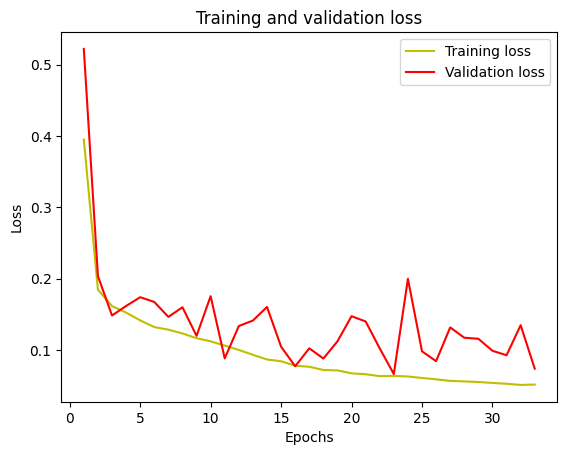

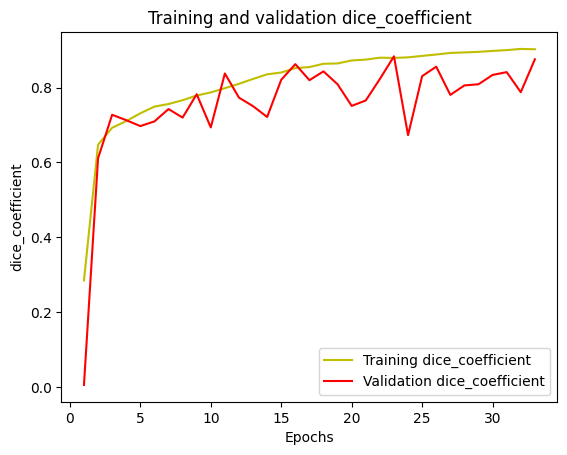

In [27]:
#plot the training and validation dice_coefficient and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

dice_coefficient = history.history['dice_coefficient']
val_dice_coefficient = history.history['val_dice_coefficient']

plt.plot(epochs, dice_coefficient, 'y', label='Training dice_coefficient')
plt.plot(epochs, val_dice_coefficient, 'r', label='Validation dice_coefficient')
plt.title('Training and validation dice_coefficient')
plt.xlabel('Epochs')
plt.ylabel('dice_coefficient')
plt.legend()
plt.show()

In [26]:
#Test patient specific
images = np.load('/volper/users/aessamla/codes/Deep_learning/tab_img_cn1.npy')
masks= np.load('/volper/users/aessamla/codes/Deep_learning/tab_seg_cn1.npy')

PermissionError: [Errno 13] Permission denied: '/volper/users/aessamla/codes/Deep_learning/tab_img_cn1.npy'

In [ ]:
masks= np.load('/volper/users/aessamla/codes/Deep_learning/tab_seg_cn1.npy')

In [ ]:
dependencies = {
    'dice_coefficient': dice_coefficient
}

from tensorflow import keras
model2 = keras.models.load_model('/volper/users/aessamla/codes/Model_test/model2.h5', custom_objects=dependencies)

In [ ]:
for i in range(images.shape[0]):
  #test_img_number = random.randint(0, len(X_test)-1)
  test_img = X_test[i]
  ground_truth=y_test[i]
  test_img_norm=test_img
  test_img_input=np.expand_dims(test_img_norm, 0)
  prediction = (model.predict(test_img_input))
  predicted_img=np.argmax(prediction, axis=3)[0,:,:]
  print('======================================')
  print('label: {}'.format(np.unique(ground_truth)))
  print('Prediction: {}'.format(np.unique(predicted_img)))
  print('======================================')